In [ ]:
import stream_analysis as sa 
import gcs 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os 
import h5py
import tstrippy
from scipy import signal
# import scienceplots
# plt.style.use(['science'])
plt.rcParams.update({
    "text.usetex": True,
})

In [2]:
def grab_valid_fnames(GCname, montecarlokey, NPs, MASS_INDEX, RADIUS_INDEX, potential_env, internal_dynamics):
    valid_NPs=[]
    fnames=[]
    for i in range(len(NPs)):
        fname = gcs.path_handler.StreamMassRadius(
            GCname=GCname,
            NP=NPs[i],
            potential_env=potential_env,
            internal_dynamics=internal_dynamics,
            montecarlokey=montecarlokey,
            Mass=MASS_INDEX,
            radius=RADIUS_INDEX,)
        if os.path.exists(fname):
            fnames.append(fname)
            valid_NPs.append(NPs[i])
        else:
            print("file does not exist",fname)
    valid_NPs=np.array(valid_NPs)
    return fnames,valid_NPs

In [3]:
def stack_phase_space(fnames,NPs):
    """ assumes all fnames are valid files of the same format 
    """
    # set the indicies
    cummulative_NPs = np.cumsum(NPs)
    cummulative_NPs = np.insert(cummulative_NPs, 0, 0)
    # initiate the output arrays 
    phase_space = np.zeros((6,NPs.sum()))
    tesc=np.zeros(NPs.sum())
    for i in range(len(fnames)):
        with h5py.File(fnames[i],"r") as f:
            phase_space[:,cummulative_NPs[i]:cummulative_NPs[i+1]] = f["phase_space"][:]
            tesc[cummulative_NPs[i]:cummulative_NPs[i+1]] = f['tesc'][:]
    return phase_space, tesc

In [4]:
pagewidth=8.3
margintotal = (1-0.72)*pagewidth

In [5]:
def prepare_fig(figsize=(pagewidth-margintotal, 2)):
    fig=plt.figure(figsize=figsize)
    gs = mpl.gridspec.GridSpec(2, 2, figure=fig,width_ratios=[1, 1/50], height_ratios=[1, 1],hspace=0.50, wspace=0)
    cax = fig.add_subplot(gs[:, 1])
    axes = []
    for i in range(2):
        axes.append(fig.add_subplot(gs[i, 0]))
    return fig, axes, cax

In [6]:
# make the histogram on the same grid by binning subsets
def create_histograms(particles, groups, limits=[-20,20]):
    """
    Create histograms for each group of particles in the specified limits.
    Parameters:
    particles : array_like
        The data to be binned.
    groups : list of array_like BOOLEANS
        The groups of particles to be binned.
    limits : list
        The limits for the histogram bins.
    Returns:
    counts : list of array_like
        The counts for each group.
    bin_centers : array_like
        The centers of the bins.
    """
    nbins = int(np.ceil(np.sqrt(particles.shape[0])))
    bmin= limits[0]
    bmax= limits[1]
    bin_edges = np.linspace(bmin, bmax, nbins+1)
    counts = []
    for i in range(len(groups)):
        group = groups[i]
        hist, _ = np.histogram(particles[group], bins=bin_edges)
        counts.append(hist)
    return counts, bin_edges


In [7]:
# plot params 
xlims=[-13,13]
ylims=[-0.5,0.5]
cmap = mpl.cm.rainbow
vmax=1e2
vmin=1

In [8]:
### DATA PARAMS 

GCname = "Pal5"
NP = 9100
potential_env = "pouliasis2017pii-GCNBody"
internal_dynamics = "isotropic-plummer_mass_radius_grid"
montecarlokey = "monte-carlo-009"
PerturberName = "NGC7078"
radiusIndex = 4
massIndex = 0
massIndex2 = 2

# get the particle counts per file
start = 9100
stop = 10000
step = 100
append = 4500
NPs = np.arange(start, stop+step, step)
NPs = np.append(NPs, append)

In [9]:
# get the host orbit 
pathorbit=gcs.path_handler.GC_orbits(potential_env,GCname)
tGC,xGC,yGC,zGC,vxGC,vyGC,vzGC=gcs.extractors.GCOrbits.extract_whole_orbit(pathorbit,montecarlokey)
# now chop the orbit down 
tGC,xGC,yGC,zGC,vxGC,vyGC,vzGC=sa.tailCoordinates.filter_orbit_by_dynamical_time(tGC,xGC,yGC,zGC,vxGC,vyGC,vzGC,time_of_interest=0,nDynTimes=2.5)

In [10]:
# extract all the phase space data
fnames,validNPS=grab_valid_fnames(GCname, montecarlokey, NPs, massIndex, radiusIndex, potential_env, internal_dynamics)
phase_space0, tesc0=stack_phase_space(fnames,validNPS)
with h5py.File(fnames[0],"r") as myfile:
    # get the mass of the stars
    Mass0=myfile.attrs['MASS']

In [11]:

# now put it into tail coordinates
xp,yp,zp,vxp,vyp,vzp,_=sa.tailCoordinates.transform_from_galactico_centric_to_tail_coordinates(
    phase_space0[0],phase_space0[1],phase_space0[2],
    phase_space0[3],phase_space0[4],phase_space0[5],
    tGC,xGC,yGC,zGC,vxGC,vyGC,vzGC,
    t0=0,
)
X0,Y0,H0=sa.plotters.binned_density.short_cut(validNPS.sum(), xp, yp,xlims=xlims,ylims=ylims)
X0,Y0,H0=sa.plotters.binned_density.order_by_density(X0,Y0,H0)

In [12]:
# get the second mass index
fnames,validNPS=grab_valid_fnames(GCname, montecarlokey, NPs, massIndex2, radiusIndex, potential_env, internal_dynamics)
phase_space1, tesc1=stack_phase_space(fnames,validNPS)
# get the mass
with h5py.File(fnames[0],"r") as myfile:
    Mass1=myfile.attrs['MASS']

In [13]:
# now put it into tail coordinates
xp,yp,zp,vxp,vyp,vzp,_=sa.tailCoordinates.transform_from_galactico_centric_to_tail_coordinates(
    phase_space1[0],phase_space1[1],phase_space1[2],
    phase_space1[3],phase_space1[4],phase_space1[5],
    tGC,xGC,yGC,zGC,vxGC,vyGC,vzGC,
    t0=0,
)
X1,Y1,H1=sa.plotters.binned_density.short_cut(validNPS.sum(), xp, yp,xlims=xlims,ylims=ylims)
X1,Y1,H1=sa.plotters.binned_density.order_by_density(X1,Y1,H1)

In [14]:
norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
cmap = mpl.cm.rainbow

In [15]:
AXES0={
    "xlim":xlims,
    "ylim":ylims,
    "xticks":[],
    "yticks":[-0.5,0,0.5],
    "title":fr"${Mass0:.0f}\ M_\odot$",
}
AXES1={
    "xlim":xlims,
    "ylim":ylims,
    "xlabel":r"$x_{tail} \textrm{ [kpc]}$",
    "yticks":[-0.5,0,0.5],
    "xticks":np.arange(-12,12+3,3),
    "title":fr"${Mass1:.0f}\ M_\odot$",
}
SCAT = {
    "s":0.1,
    "cmap":cmap,
    "alpha":0.9,
    "norm":norm,
}

FIG={
    "supylabel": r"$y_{tail} \textrm{ [kpc]}$",
}

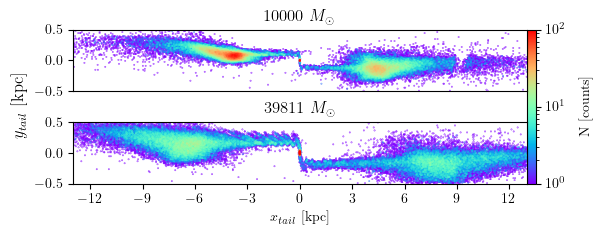

In [16]:
fig,axes,cax=prepare_fig()
axes[0].scatter(X0,Y0,c=H0,**SCAT)
axes[0].set(**AXES0)
axes[1].scatter(X1,Y1,c=H1,**SCAT)
axes[1].set(**AXES1);
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label(r"$\textrm{N [counts}]$", rotation=90, labelpad=10)
fig.supylabel(FIG["supylabel"])
fig.savefig("../paper/gap_no_more.png", dpi=300, bbox_inches='tight')

In [17]:
# do the weighed histogram
Nbins = int(np.sqrt(NPs.sum()))
edges = np.linspace(xlims[0], xlims[1], Nbins)
centers=0.5*(edges[1:]+edges[:-1])
counts0,_=np.histogram(X0,weights=H0,bins=edges)
counts1,_=np.histogram(X1,weights=H1,bins=edges)

(-13.0, 13.0)

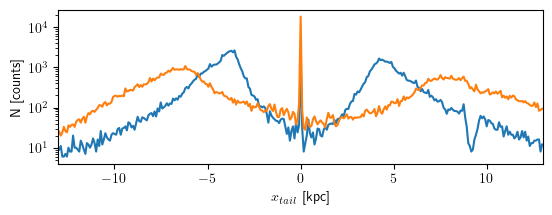

In [18]:
fig,axis=plt.subplots(figsize=(8.25-2, 2))
axis.plot(centers,counts0, label="mass index 0", color="C0")
axis.plot(centers,counts1, label="mass index 2", color="C1")
axis.set_yscale("log")
axis.set_xlabel("$x_{tail}$ [kpc]")
axis.set_ylabel("N [counts]")
axis.set_xlim(xlims)

# Get the groups of pericenter passages

In [19]:
mycmap = mpl.cm.jet

In [20]:
# load the whole orbit 
pathorbit=gcs.path_handler.GC_orbits(potential_env,GCname)
torbit,xorbit,yorbit,zorbit,vxorbit,vyorbit,vzorbit=gcs.extractors.GCOrbits.extract_whole_orbit(pathorbit,montecarlokey)

In [21]:
# Locate the pericenter passages
rorbit = np.sqrt(xorbit**2 + yorbit**2 + zorbit**2)
minima_indices, _ = signal.find_peaks(-rorbit)

In [22]:
# Compute the characteristic time of the shocks
pouliasis2017pii = tstrippy.Parsers.pouliasis2017pii()
ax, ay, az, _ = tstrippy.potentials.pouliasis2017pii(pouliasis2017pii, xorbit[minima_indices], yorbit[minima_indices], zorbit[minima_indices])
accel = np.sqrt(ax**2 + ay**2 + az**2)
chartimes = np.sqrt(rorbit[minima_indices] / accel)

In [23]:
# Find the upper and lower bounds of the time of interest
pericenter_passages_indices = []
for i in range(len(minima_indices) - 1):
    downTime = torbit[minima_indices[i]] - chartimes[i]
    upTime = torbit[minima_indices[i]] + chartimes[i]
    minDex = np.argmin(np.abs(torbit - downTime))
    upDex = np.argmin(np.abs(torbit - upTime))
    pericenter_passages_indices.append((minDex, upDex))


In [24]:
# Obtain the groups of escaped stars that are not from the same pericenter passage
groups = []
cond = np.zeros(len(tesc1), dtype=bool)
for ii in range(len(pericenter_passages_indices)):
    minDex, upDex = pericenter_passages_indices[ii]
    condA = tesc1 > torbit[minDex]
    condB = tesc1 < torbit[upDex]
    condC = np.logical_and(condA, condB)
    groups.append(condC)
    cond = np.logical_or(cond, condC)
ungroupped = ~cond

In [25]:
# Create histograms
counts_groups, bin_edges = create_histograms(xp, groups, xlims)
counts_leak, _ = np.histogram(xp[ungroupped], bins=bin_edges)
counts_total, _ = np.histogram(xp, bins=bin_edges)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])    
# make a groupped total 
counts_grouped = np.zeros_like(counts_total)
for i in range(len(counts_groups)):
    counts_grouped += counts_groups[i]

In [26]:
# Set the colors for the tree
mycmap = mpl.cm.twilight_shifted
colors = mycmap(np.linspace(0, 1, len(minima_indices)))

In [27]:
AXIS0 = {
    "xlim": xlims,
    "ylim": [1,  np.max(counts_total)],
    "xticks": [],
    "yscale": "log",
    "yticks": [1, 10, 100, 1000],
    "ylim":[1,1e3]
}
AXIS1 = {
    "xlim": xlims,
    "ylim": [1,  np.max(counts_total)],
    "xticks": [],
    "yscale": "log",
    "yticks": [1, 10, 100, ],
    "ylim":[1,1e3]
}
AXIS2 = {
    "xlim": xlims,
    "ylim": [1,  np.max(counts_total)],
    "xticks": [],
    "yscale": "log",
    "yticks": [1, 10, 100,],
    "ylim":[1,1e3]
}

AXIS3 = {
    "xlim": xlims,
    "ylim": [1,  np.max(counts_total)],
    "xlabel": r"$x_{tail} \textrm{ [kpc]}$",
    "xticks": np.arange(-12, 12 + 3, 3),
    "yscale": "log",
    "yticks": [1, 10, 100, ],
    "ylim":[1,1e3]
}

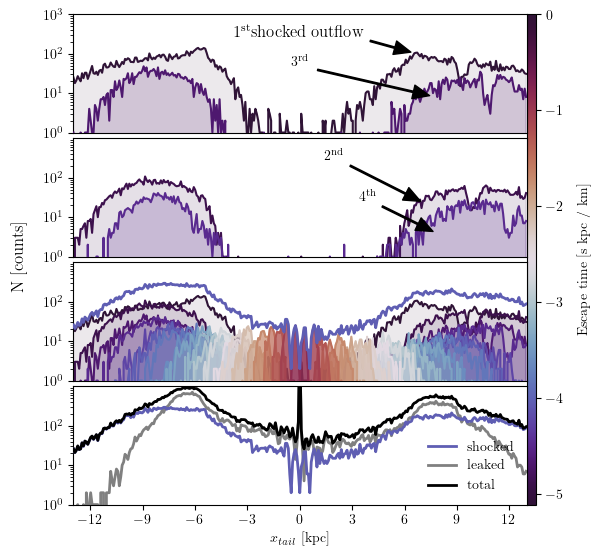

In [29]:
npericenterpassages = len(groups)

fig=plt.figure(figsize=(pagewidth-margintotal, 11.69-margintotal-3))
gs = mpl.gridspec.GridSpec(4, 2, figure=fig,width_ratios=[1, 1/50],wspace=0,hspace=0.05)
cax = fig.add_subplot(gs[:, 1])
axes=[]
axes.append(fig.add_subplot(gs[0, 0]))
axes.append(fig.add_subplot(gs[1, 0]))
axes.append(fig.add_subplot(gs[2, 0]))
axes.append(fig.add_subplot(gs[3, 0]))



# Add shaded areas for each group
floor = 0.1
# for i in range(npericenterpassages):
for i in range(0,4,2):
    alpha = (i/npericenterpassages + floor) / (1+floor)
    y = counts_groups[i]
    color = colors[i]
    # Set label for last group
    label = "shocked outflow" if i == npericenterpassages-1 else None
    # Create shaded area
    axes[0].fill_between(bin_centers, y, 0, 
                        color=color, 
                        alpha=alpha, 
                        zorder=i+1,
                        label=label)
    axes[0].plot(bin_centers, y, color=color, alpha=1, zorder=i+1)

for i in range(1,4,2):
    alpha = (i/npericenterpassages + floor) / (1+floor)
    y = counts_groups[i]
    color = colors[i]
    # Set label for last group
    label = "shocked outflow" if i == npericenterpassages-1 else None
    # Create shaded area
    axes[1].fill_between(bin_centers, y, 0, 
                        color=color, 
                        alpha=alpha, 
                        zorder=i+1,
                        label=label)
    axes[1].plot(bin_centers, y, color=color, alpha=1, zorder=i+1)


for i in range(0,npericenterpassages,1):
    alpha = ((i)/npericenterpassages + floor) / (1+floor)
    y = counts_groups[i]
    color = colors[i]
    # Set label for last group
    label = "shocked outflow" if i == npericenterpassages-1 else None
    # Create shaded area
    axes[2].fill_between(bin_centers, y, 0, 
                        color=color, 
                        alpha=alpha, 
                        zorder=i+1,
                        label=label)
    axes[2].plot(bin_centers, y, color=color, alpha=1, zorder=i)

axes[3].plot(bin_centers, counts_grouped,   label=r"$\textrm{shocked}$", color=colors[5], lw=2,zorder=npericenterpassages+1)
axes[2].plot(bin_centers, counts_grouped,   label=r"$\textrm{shocked}$", color=colors[5], lw=2,zorder=npericenterpassages+1)
axes[3].plot(bin_centers, counts_leak,      label=r"$\textrm{leaked}$", color="gray", lw=2)
axes[3].plot(bin_centers, counts_total,     label=r"$\textrm{total}$", color="k", lw=2,zorder=npericenterpassages+10)
legend=axes[3].legend(fontsize="medium", frameon=False,)
# get the current legend position 



axes[0].annotate(r"$1^{\mathrm{st}} \textrm{shocked outflow}$", xytext=(0.5,0.85), xy=(0.75, 0.675),
                 xycoords="axes fraction", ha="center", va="center", fontsize="large",
                            arrowprops=dict(facecolor='black', shrink=0.05, width=1., headwidth=10))

axes[0].annotate(r"$3^{\mathrm{rd}}$",xytext=(0.50,0.6),  xy=(0.8, 0.3), 
                 xycoords="axes fraction", ha="center", va="center", fontsize="medium",
                            arrowprops=dict(facecolor='black', shrink=0.05, width=1., headwidth=10))

axes[1].annotate(r"$2^{\mathrm{nd}}$ ", xytext=(0.575,0.85), xy=(0.775, 0.45),
                 xycoords="axes fraction", ha="center", va="center", fontsize="medium",
                            arrowprops=dict(facecolor='black', shrink=0.05, width=1., headwidth=10))

axes[1].annotate(r"$4^{\mathrm{th}}$",xytext=(0.65,0.5),  xy=(0.8, 0.2), 
                 xycoords="axes fraction", ha="center", va="center", fontsize="medium",
                            arrowprops=dict(facecolor='black', shrink=0.05, width=1., headwidth=10),zorder=25)


sm = mpl.cm.ScalarMappable(cmap=mycmap, norm=mpl.colors.Normalize(vmin=torbit[0], vmax=0))
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label(r"$\textrm{Escape time [s kpc / km]}$", rotation=90, labelpad=10)
axes[0].set(**AXIS0);
axes[1].set(**AXIS1);
axes[2].set(**AXIS2);
axes[3].set(**AXIS3);
fig.supylabel(r"$\textrm{N [counts]}$")

fig.savefig("../paper/decoherence_shocked_outflow.png", dpi=300, bbox_inches='tight')